# Treino do zero (*from scratch*)

Neste script vamos conhecer a estratégia de treino tradicional de redes neurais em geral: **O treino do zero (*from scratch*)**. <br>
Trataremos do uso mais tradicional de CNNs: **classificação de imagens**.


Primeiro de tudo, vamos fazer os imports.

In [1]:
# Implementação e treinamento da rede
import random
import torch
from torch import nn, optim

# Carregamento de Dados
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from torch import optim

# Plots e análises
# Métrica de acurácia do scikit-learn.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time, os

# Visualização de matrizes em formato de heatmap.
import seaborn as sns

# Define um valor de semente único a ser usado por todas as bibliotecas.
SEED = 42

# Fixa a semente do gerador aleatório do Python (random).
random.seed(SEED)

# Fixa a semente do NumPy.
np.random.seed(SEED)

# Fixa a semente do PyTorch na CPU.
torch.manual_seed(SEED)

# Fixa a semente do PyTorch em todas as GPUs disponíveis (CUDA).
torch.cuda.manual_seed_all(SEED)

%matplotlib inline

In [2]:
# Configurando hiperparâmetros.
args = {
    'epoch_num': 150,     # Número de épocas.
    'lr': 1e-3,           # Taxa de aprendizado.
    'weight_decay': 1e-3, # Penalidade L2 (Regularização).
    'batch_size': 50,     # Tamanho do batch.
}

# Definindo dispositivo de hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

# Intra-op = kernels (convoluções etc.), Inter-op = paralelismo entre ops
torch.set_num_threads(8)           # ~ núcleos físicos (8)
torch.set_num_interop_threads(1)   # inter-op baixo ajuda na CPU

# oneDNN (mkldnn) costuma acelerar no CPU; já é True por padrão.
torch.backends.mkldnn.enabled = True

cpu


## Carregamento de Dados

Usaremos o dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), um conjunto de imagens RGB divididas em 10 categorias de objeto: avião, automóvel, pássaro, gato, veado, cachorro, sapo, cavalo, navio, caminhão. As imagens possuem $32 \times 32$ pixels.

Trata-se de um dataset de 60 mil imagens naturais (do mundo real), muito utilizado para avaliar a qualidade de modelos de aprendizado profundo.

https://pytorch.org/docs/stable/torchvision/datasets.html#cifar

In [3]:
data_transform = transforms.Compose([
                                     transforms.Resize(32),
                                     transforms.ToTensor(),])

train_set = datasets.CIFAR10('.', 
                      train=True, 
                      transform=data_transform, 
                      download=True)

test_set = datasets.CIFAR10('.', 
                      train=False, 
                      transform=data_transform, 
                      download=False)

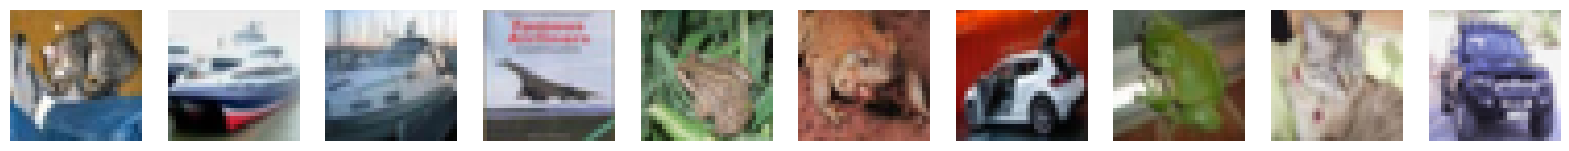

In [4]:
fig, axs = plt.subplots(1,10, figsize=(20, 2))
for i in range(10):
  data, label = test_set[i]
  axs[i].imshow(data.permute((1,2,0)))
  axs[i].axis('off')

In [5]:
SEED=42

g = torch.Generator().manual_seed(SEED)

# Define uma função de inicialização por worker do DataLoader (executada em cada processo de leitura).
def _worker_init_fn(worker_id):
    # Garante que cada worker não use múltiplas threads BLAS (evita competir com o treino).
    # Garantir que cada worker não roube threads do treino
    rs = SEED + worker_id
    random.seed(rs); np.random.seed(rs); torch.manual_seed(rs)
    # Limita threads do OpenMP usadas por libs como NumPy/SciPy.
    os.environ["OMP_NUM_THREADS"] = "1"
    # Limita threads do backend MKL.
    os.environ["MKL_NUM_THREADS"] = "1"
    # Limita threads do OpenBLAS.
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    # Tenta também forçar o PyTorch no worker a usar 1 thread para computação intra/inter-op.
    try:
        # Define 1 thread para operações internas (intra-op).
        torch.set_num_threads(1)        # por segurança também no worker
        # Define 1 thread para paralelismo entre operações (inter-op).
        torch.set_num_interop_threads(1)
    # Se a API não existir no ambiente, apenas segue em frente.
    except Exception:
        pass



# Número de processos de leitura para o loader de treino.
NUM_WORKERS_TRAIN = 8
# Número de processos de leitura para o loader de teste/validação (geralmente menor).
NUM_WORKERS_TEST  = 4

# Cria o DataLoader de TREINO com configurações de performance para CPU.
train_loader = DataLoader(
    # Dataset de treino previamente instanciado.
    train_set,
    # Tamanho do mini-batch; no CPU é comum testar 64 ou 128 (aqui vem de args).
    batch_size=args['batch_size'],   # sugiro testar 64 e 128 no CPU; comece por 64
    # Embaralha amostras a cada época (boa prática no treino).
    shuffle=True,
    # Quantidade de processos workers para carregar dados em paralelo.
    num_workers=NUM_WORKERS_TRAIN,
    # No CPU, deixar False (pinning ajuda apenas para transferir para GPU).
    pin_memory=False,                # CPU: False
    # Mantém os workers vivos entre épocas (reduz overhead de criação).
    persistent_workers=True,
    # Nº de lotes pré-carregados por worker (prefetch) para alimentar a fila.
    prefetch_factor=2,
    # ???? Descarta o último lote se ele for menor que batch_size (estabiliza shapes).
    drop_last=False,
    # Função de init para cada worker (limita threads internas).
    worker_init_fn=_worker_init_fn,
    generator=g,
)

# Cria o DataLoader de TESTE/validação (sem embaralhar e com menos workers).
test_loader = DataLoader(
    # Dataset de teste previamente instanciado.
    test_set,
    # Mesmo tamanho de lote do treino (pode aumentar se couber na RAM).
    batch_size=args['batch_size'],
    # Em avaliação normalmente mantemos a ordem fixa.
    shuffle=False,
    # Menos workers costumam ser suficientes no teste.
    num_workers=NUM_WORKERS_TEST,
    # No CPU, pin_memory desnecessário.
    pin_memory=False,
    # Mantém os workers entre iterações para reduzir overhead.
    persistent_workers=True,
    # Prefetch de 2 lotes por worker para suavizar leitura.
    prefetch_factor=2,
    # Mesma função de init para controlar threads nos workers.
    worker_init_fn=_worker_init_fn,
    generator=g,
)


## LeNet 5

Primeiro de tudo, precisamos **implementar uma CNN**. Sim, chegou a hora de colocar em prática tudo que já sabemos sobre redes convolucionais, montando uma arquitetura completa!

A arquitetura escolhida para essa aula é a LeNet. Ela é a primeira CNN bem sucedida da história, [proposta em 1998 pelo Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). 

<img src="https://drive.google.com/uc?export=view&id=1BThCsFE8fSCe012klZmp8UpslOlzWsmK" width="800">

<img src="https://drive.google.com/uc?export=view&id=1oG_Jh8nA2Nrq8RTcIyJEOaIXXxa10Srw" width="700">

Vamos implementar blocos convolucionais incluindo todas as camadas que aprendemos nesse curso:
```python
net = nn.Sequential(
          nn.Conv2d(...),
          nn.BatchNorm2d(...),
          nn.Tanh(), # Ativação específica da LeNet
          nn.AvgPool2d(...), # Pooling específico da LeNet
      )
```

In [6]:
# Definindo a rede
net = nn.Sequential(
        ## ConvBlock 1
        nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),        # entrada: (b, 3, 32, 32) e saida: (b, 6, 28, 28)
        nn.BatchNorm2d(6),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 6, 28, 28) e saida: (b, 6, 14, 14)
        
        ## ConvBlock 2
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),       # entrada: (b, 6, 14, 14) e saida: (b, 16, 10, 10)
        nn.BatchNorm2d(16),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 16, 10, 10) e saida: (b, 16, 5, 5)
        
        ## ConvBlock 3
        nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),     # entrada: (b, 16, 5, 5) e saida: (b, 120, 1, 1)
        nn.BatchNorm2d(120),
        nn.Tanh(),
        nn.Flatten(),  # lineariza formando um vetor                # entrada: (b, 120, 1, 1) e saida: (b, 120*1*1) = (b, 120)
        
        ## DenseBlock
        nn.Linear(120, 84),                                         # entrada: (b, 120) e saida: (b, 84)
        nn.Tanh(),
        nn.Linear(84, 10),                                          # entrada: (b, 84) e saida: (b, 10)
        )

# Subindo no hardware de GPU (se disponível)
net = net.to(args['device'])

VGG16

In [7]:
# # Definindo a rede
# net = nn.Sequential(
#         ## ConvBlock 1
#         nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),      # entrada: (b, 3, 224, 224) e saida: (b, 64, 224, 224)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 64, 224, 224) e saida: (b, 64, 112, 112)
        
#         ## ConvBlock 2
#         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),    # entrada: (b, 64, 112, 112) e saida: (b, 128, 112, 112)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 128, 112, 112) e saida: (b, 128, 56, 56)
        
#         ## ConvBlock 3
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 128, 56, 56) e saida: (b, 256, 56, 56)
#         nn.ReLU(),
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 56, 56) e saida: (b, 256, 56, 56)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 256, 56, 56) e saida: (b, 256, 28, 28)
        
#         ## ConvBlock 4
#         nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 256, 28, 28) e saida: (b, 512, 28, 28)
#         nn.ReLU(),
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 28, 28) e saida: (b, 512, 28, 28)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 512, 28, 28) e saida: (b, 512, 14, 14)
        
#         ## ConvBlock 4
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 14, 14) e saida: (b, 512, 14, 14)
#         nn.ReLU(),
#         nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # entrada: (b, 512, 14, 14) e saida: (b, 512, 14, 14)
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # entrada: (b, 512, 14, 14) e saida: (b, 512, 7, 7)
#         nn.Flatten(),  # lineariza formando um vetor               # entrada: (b, 512, 7, 7) e saida: (b, 512*7*7) = (b, 25088)
 
#         ## DenseBlock
#         nn.Linear(25088, 4096),                                    # entrada: (b, 25088) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(4096, 4096),                                     # entrada: (b, 4096) e saida: (b, 4096)
#         nn.ReLU(),
#         nn.Linear(4096, 10),                                       # entrada: (b, 4096) e saida: (b, 10)
#         nn.Softmax(dim=-1)
#         )

# # Subindo no hardware de GPU (se disponível)
# net = net.to(args['device'])

#Estratégias de Treino

## Do zero (From scratch)

O primeiro passo do treinamento do zero é definir os algoritmos que serão utilizados no processo de treinamento. Eles são:

* **Função de perda**, que vai avaliar a qualidade da performance da rede a cada passo de treinamento;
* **Otimizador**, que a partir da função de perda vai definir a melhor forma de atualizar os pesos.

In [8]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

Relembrando o passo a passo do fluxo de treinamento:

* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Zerar o gradiente do otimizador
* Cálculo do gradiente e atualização dos pesos

Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir a média e o desvio padrão das perdas de cada iteração.

In [9]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()
    

### Validação

Para essa etapa, o PyTorch oferece dois artifícios:
* ```model.eval()```: Impacta no *forward* da rede, informando as camadas caso seu comportamento mude entre fluxos (ex: dropout).
* ```with torch.no_grad()```: Gerenciador de contexto que desabilita o cálculo e armazenamento de gradientes (economia de tempo e memória). Todo o código de validação deve ser executado dentro desse contexto.

Exemplo de código para validação

```python
net.eval()
with torch.no_grad():
  for batch in test_loader:
      # Código de validação
```

Existe o equivalente ao ```model.eval()``` para explicitar que a sua rede deve estar em modo de treino, é o ```model.train()```. Apesar de ser o padrão dos modelos, é boa prática definir também o modo de treinamento.

In [10]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()
    

In [11]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 1.6572 +/- 0.1904, Acc: 41.05, Time: 5.96
********** Validate **********
Epoch 0, Loss: 1.5364 +/- 0.1523, Acc: 45.51, Time: 0.64

#################### Train ####################
Epoch 1, Loss: 1.4133 +/- 0.1528, Acc: 49.48, Time: 5.75
********** Validate **********
Epoch 1, Loss: 1.3738 +/- 0.1455, Acc: 50.44, Time: 0.51

#################### Train ####################
Epoch 2, Loss: 1.3300 +/- 0.1407, Acc: 52.47, Time: 5.72
********** Validate **********
Epoch 2, Loss: 1.2894 +/- 0.1406, Acc: 53.75, Time: 0.52

#################### Train ####################
Epoch 3, Loss: 1.2646 +/- 0.1504, Acc: 55.36, Time: 5.71
********** Validate **********
Epoch 3, Loss: 1.4128 +/- 0.1590, Acc: 50.97, Time: 0.51

#################### Train ####################
Epoch 4, Loss: 1.2109 +/- 0.1550, Acc: 57.18, Time: 5.75
********** Validate **********
Epoch 4, Loss: 1.2476 +/- 0.1454, Acc: 55.17, Time: 0.52

#################### Train ###

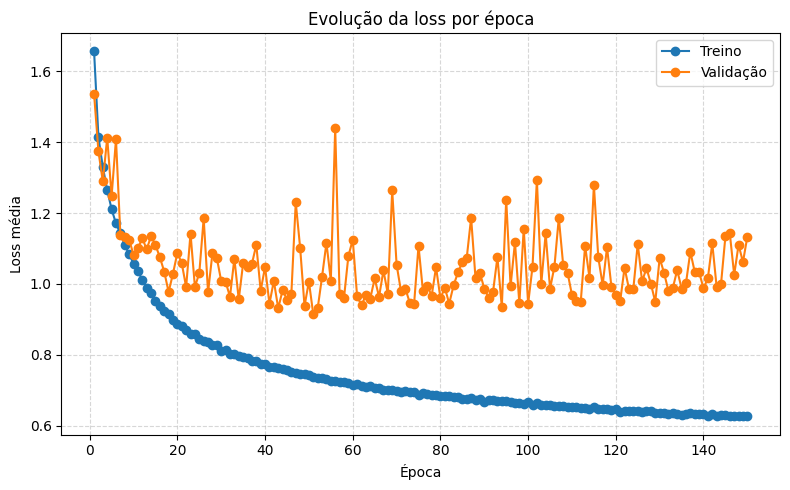

In [12]:
# Cria uma figura 8×5 para os gráficos.
plt.figure(figsize=(8, 5))

# Plota a curva da loss de treino ao longo das épocas (1..N), marcando os pontos.
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Treino', marker='o')

# Plota a curva da loss de validação ao longo das épocas, também com marcadores.
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Validação', marker='o')

# Define o título do gráfico.
plt.title('Evolução da loss por época')

# Rotula o eixo X com “Época”.
plt.xlabel('Época')

# Rotula o eixo Y com “Loss média”.
plt.ylabel('Loss média')

# Adiciona uma grade discreta para facilitar a leitura.
plt.grid(True, linestyle='--', alpha=0.5)

# Exibe a legenda para distinguir as curvas.
plt.legend()

# Ajusta os espaçamentos para evitar cortes de textos/elementos.
plt.tight_layout()

# Renderiza o gráfico na saída.
plt.show()

Relatório de classificação (teste):
              precision    recall  f1-score   support

    airplane       0.71      0.69      0.70      1000
  automobile       0.85      0.71      0.78      1000
        bird       0.67      0.38      0.48      1000
         cat       0.36      0.62      0.46      1000
        deer       0.54      0.62      0.58      1000
         dog       0.51      0.53      0.52      1000
        frog       0.85      0.52      0.64      1000
       horse       0.57      0.81      0.67      1000
        ship       0.82      0.71      0.76      1000
       truck       0.82      0.67      0.74      1000

    accuracy                           0.63     10000
   macro avg       0.67      0.63      0.63     10000
weighted avg       0.67      0.63      0.63     10000



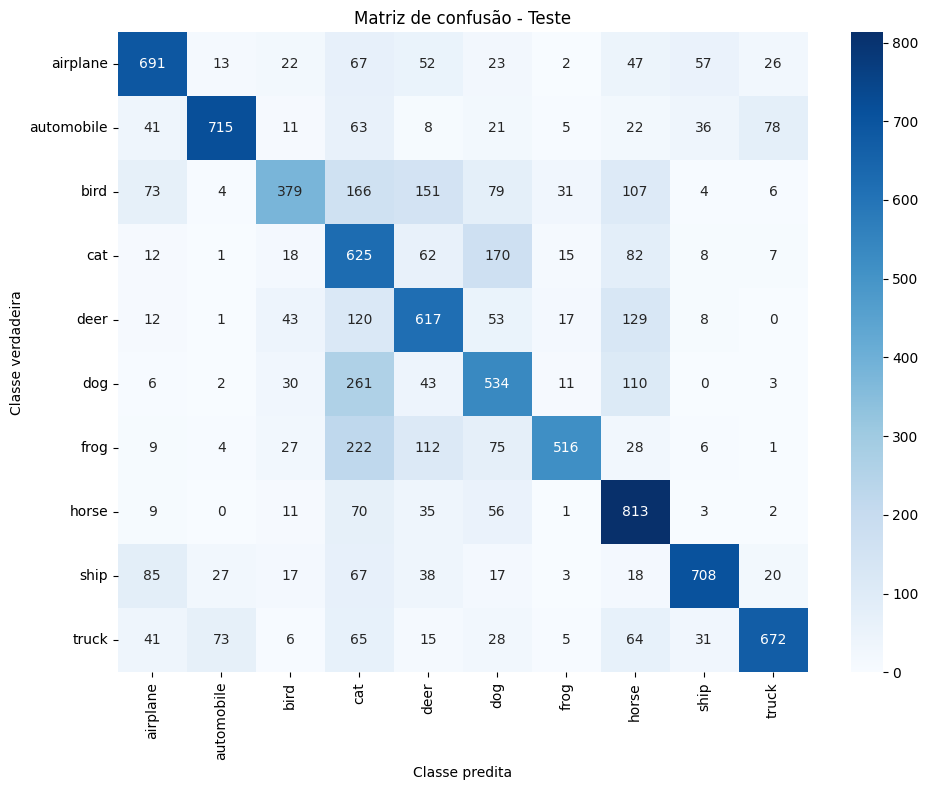

In [13]:
# Cabeçalho informativo desta seção (aviso do propósito do bloco).
# Gera métricas de classificação no conjunto de teste.

# Coloca a rede em modo de avaliação (desativa dropout e usa BN com estatísticas fixas).
net.eval()

# Inicializa listas para acumular previsões e rótulos de todos os lotes.
predicoes, alvos = [], []

# Desativa o cálculo de gradientes para acelerar a inferência e economizar memória.
with torch.no_grad():
    # Itera pelos lotes do loader de teste, recebendo imagens e rótulos verdadeiros.
    for imagens, rotulos in test_loader:
        # Move o batch de imagens para o dispositivo (CPU/GPU) configurado.
        imagens = imagens.to(args['device'])
        # Move os rótulos para o mesmo dispositivo.
        rotulos = rotulos.to(args['device'])
        # Forward: calcula os logits/saídas do modelo para o batch.
        saidas = net(imagens)
        # Converte logits em classes previstas (índice do maior logit por amostra).
        preds = saidas.argmax(dim=1)
        # Armazena as predições no CPU como NumPy para posterior concatenação.
        predicoes.append(preds.cpu().numpy())
        # Armazena os rótulos verdadeiros no CPU como NumPy.
        alvos.append(rotulos.cpu().numpy())

# Concatena todos os rótulos em um único vetor 1D (ordem dos lotes preservada).
y_true = np.concatenate(alvos)
# Concatena todas as predições em um único vetor 1D.
y_pred = np.concatenate(predicoes)
# Obtém os nomes de classe (CIFAR-10: airplane, automobile, …) do dataset de treino.
class_names = train_set.classes

# Imprime um cabeçalho textual para o relatório de classificação.
print('Relatório de classificação (teste):')
# Gera precisão/recall/F1 por classe; requer: from sklearn.metrics import classification_report.
print(classification_report(y_true, y_pred, target_names=class_names))

# Calcula a matriz de confusão (linhas = verdade, colunas = predito).
# Requer: from sklearn.metrics import confusion_matrix.
conf_mat = confusion_matrix(y_true, y_pred)

# Abre uma figura para o heatmap da matriz de confusão.
plt.figure(figsize=(10, 8))

# Plota a matriz de confusão como heatmap com rótulos nas bordas; requer: import seaborn as sns.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Define um título descritivo para o gráfico da matriz de confusão.
plt.title('Matriz de confusão - Teste')

# Rotula o eixo Y como “classe verdadeira”.
plt.ylabel('Classe verdadeira')

# Rotula o eixo X como “classe predita”.
plt.xlabel('Classe predita')

# Ajusta margens/espaçamentos para evitar cortes de textos.
plt.tight_layout()

# Renderiza o heatmap na saída.
plt.show()
